In [1]:
!gdown 1v36q7Efz0mprjAv4g6TkQM2YlDKdqOuy

Downloading...
From: https://drive.google.com/uc?id=1v36q7Efz0mprjAv4g6TkQM2YlDKdqOuy
To: /content/IMDB-Dataset.csv
100% 66.2M/66.2M [00:01<00:00, 35.0MB/s]


In [2]:
!pip install contractions

In [16]:
import pandas as pd

df = pd.read_csv('/content/IMDB-Dataset.csv')
print(df.duplicated().shape)
df = df.drop_duplicates()

(50000,)


In [4]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
stop = set(stopwords.words('english'))

def expand_contractions(text):
    return contractions.fix(text)

def process_text(text):
    wl = WordNetLemmatizer()
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    text = text.lower()
    text = expand_contractions(text)
    emoji_clean = re.compile ("["
                                u"\U0001F600-\U0001F64F" # emoticons
                                u"\U0001F300-\U0001F5FF" # symbols & pictographs
                                u"\U0001F680-\U0001F6FF" # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE )
    text = emoji_clean.sub(r'',text )
    text = re.sub (r'\.(?=\ S)', '. ',text ) #add space after full stop
    text = re.sub (r'http \S+', '', text ) # remove urls
    text = "". join([word.lower()
        for word in text if word not in string.punctuation]) # remove punctuation and make text lowercase
    text = " ". join([wl.lemmatize(word)
        for word in text.split() if word not in stop and word.isalpha()]) # lemmatize
    return text

df['review'] = df['review'].apply(process_text)

<ipython-input-5-faf1a0f9c647>:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


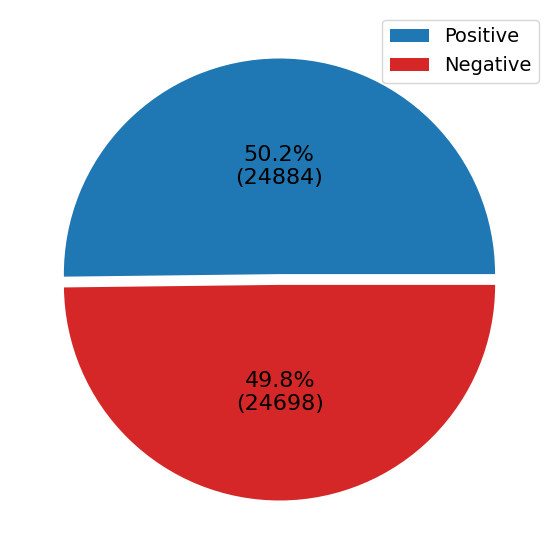

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]

labels = ['positive', 'negative']

pie, ax = plt.subplots(figsize=[11,7])
plt.pie(x = data, autopct=lambda pct: func(pct, data), explode = [0.025]*2,
        pctdistance = 0.5, colors = [sns.color_palette()[0], 'tab:red'], textprops={
            'fontsize': 16
        })
labels = [r'Positive', r'Negative']
plt.legend(labels, loc = 'best', prop = {'size': 14})
pie.savefig('PieChart.png')
plt.show()



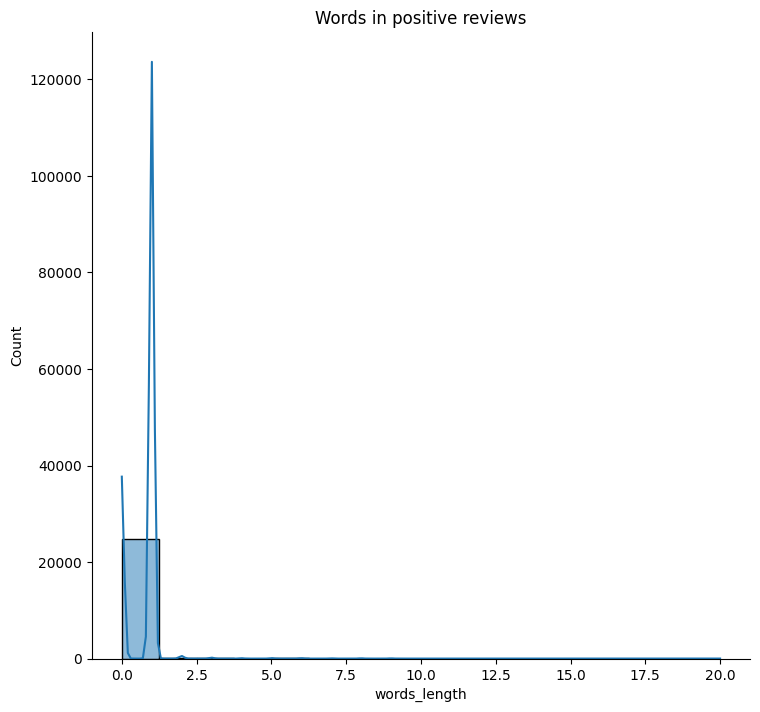

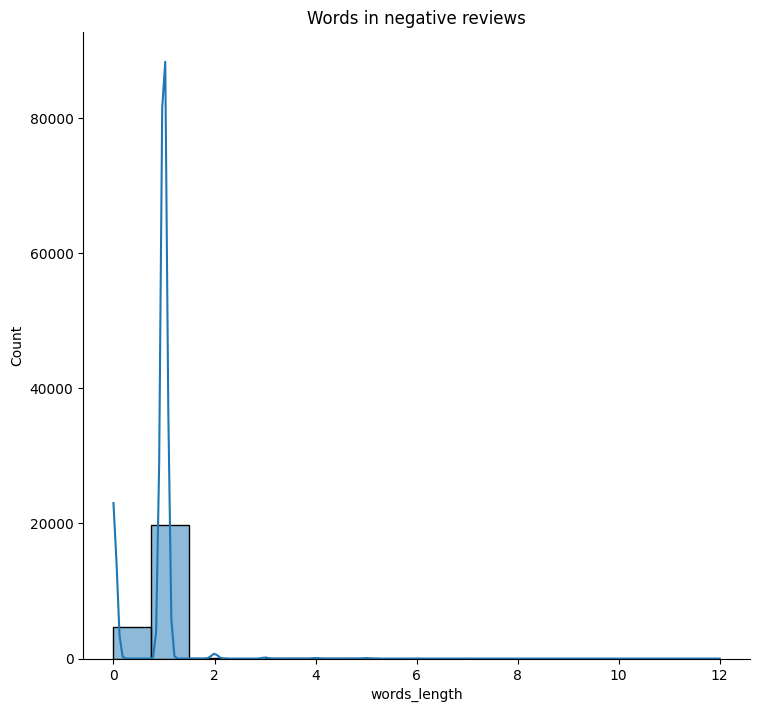

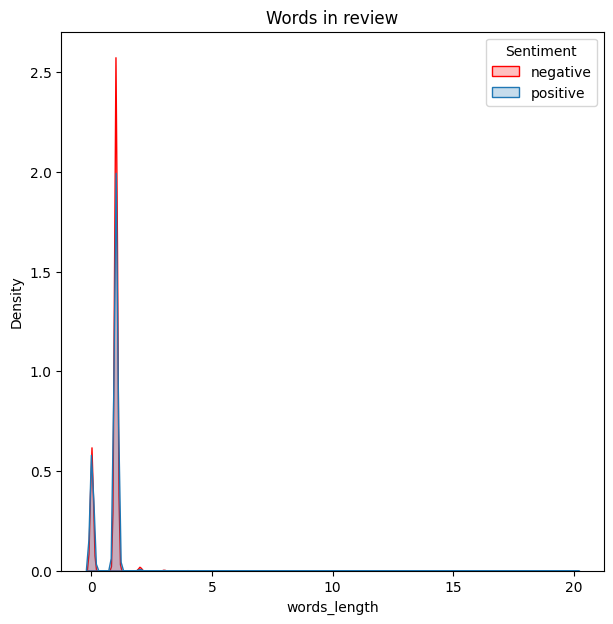

In [7]:
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words_length'] = words_len

hist_positive = sns.displot(
    data = df_temp[df_temp['sentiment'] == 'positive'],
    x = 'words_length', hue = 'sentiment', kde = True, height = 7, aspect = 1.1,
    legend = False,
).set(title = 'Words in positive reviews')
plt.show(hist_positive)

hist_negative = sns.displot(
    data = df_temp[df_temp['sentiment'] == 'negative'],
    x = 'words_length', hue = 'sentiment', kde = True, height = 7, aspect = 1.1,
    legend = False,
).set(title = 'Words in negative reviews')
plt.show(hist_negative)

plt.figure(figsize = (7, 7))
kernel_distribution_number_words_plot = sns.kdeplot(
    data = df_temp, x = 'words_length', hue = 'sentiment', fill = True,
    palette = [sns.color_palette()[0], 'red']).set(title = 'Words in review')
plt.legend(title = 'Sentiment', labels = ['negative', 'positive'])
plt.show(kernel_distribution_number_words_plot)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df['sentiment'])
x_data = df['review']

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size = 0.2, random_state = 42)

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_features = 10000)
tfidf_vectorizer.fit(x_train, y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

dt_classifier = DecisionTreeClassifier(random_state = 42, criterion = 'entropy')
dt_classifier.fit(x_train_encoded, y_train)

y_pred = dt_classifier.predict(x_test_encoded)
accuracy_score(y_test, y_pred)

0.5019663204598165

In [12]:
rf_classifier = RandomForestClassifier(random_state = 42, criterion = 'entropy')
rf_classifier.fit(x_train_encoded, y_train)

y_pred_rf = rf_classifier.predict(x_test_encoded)
accuracy_score(y_pred_rf, y_test)

0.5019663204598165